In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [2]:
txt = """Host: www.leagueofgraphs.com
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0"""

headers = {x.split(":")[0]:x.split(":")[1].strip()  for x in txt.split("\n")}

SPECIAL_NAMES = {
    "nunu&willump":"nunu",
    "wukong":"monkeyking"
}


In [3]:
CHAMP = "Zac"
ROLE = "jungle"
RANK = "diamond"
N_PAGES_TO_ANALYZE = 40 # each page contains 5 games
URL_CHAMP = CHAMP.lower().replace("'","").replace(" ","")
URL_CHAMP = SPECIAL_NAMES.get(URL_CHAMP,URL_CHAMP)

items = []
for i in range(1,N_PAGES_TO_ANALYZE+1):
    print(i, len(items))
    url = f"https://www.leagueofgraphs.com/replays/all/{URL_CHAMP}/{ROLE}/{RANK}/page-{i}"
    print(url)

    data = requests.get(url, headers=headers)

    soup = BeautifulSoup(data.text, "html.parser")

    items += soup.find_all("div",{"class":"box matchBox"})

1 0
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-1
2 5
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-2
3 10
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-3
4 15
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-4
5 20
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-5
6 25
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-6
7 30
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-7
8 35
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-8
9 40
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-9
10 45
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-10
11 50
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-11
12 55
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-12
13 60
https://www.leagueofgraphs.com/replays/all/zac/jungle/diamond/page-13
14 65
https://www.leagueofgraphs

In [4]:
len(items)

200

In [5]:
res = []

def get_summoner_data(summoner):
    global res
    data_tmp = requests.get(summoner, headers=headers)
    soup_tmp = BeautifulSoup(data_tmp.text, "html.parser")

    games = soup_tmp.find_all("div", {"class":"pie-chart-title"})
    if games:
        games = [x for x in games if x.text.strip() == "Played"][0]
        games = games.parent.find("div").text.strip()
    else:
        games = 0

    wr = soup_tmp.find_all("div", {"class":"pie-chart-title"})
    if wr:
        wr = [x for x in wr if x.text.strip() == "Winrate"][0]
        wr = wr.parent.find("div").text.strip()
    else:
        wr = 0

    rows = soup_tmp.find_all("td", {"class":"kdaColumn"})
    kda_list = [
        [
            int(y) 
            for y in x.find("div", {"class":"kda"}).text.split("\n")
             if y.isdigit()
        ] 
        for x in rows
    ]
    kda_list = [(x[0]+x[2])/max(x[1],1) for x in kda_list]

    replays = [
        1 if x.find("button") else 0
        for x in rows
    ]

    replay_links = [ "https://www.leagueofgraphs.com" + x.find("a").get("href") for x in rows ]

    win_list = [
        x.text for x in soup_tmp.find_all("div", {"class":"victoryDefeatText"})[::2]
    ]

    replay_list = [
        {
            "link":link,
            "kda":kda,
            "win":win
        }
        for link,replay,kda,win in zip(replay_links,replays,kda_list,win_list)
        if replay
    ]

    replay_list.sort(key=lambda x:x["kda"])

    tmp = {
        "is_win": is_win,
        "summoner": summoner,
        "link": "https://www.leagueofgraphs.com"+link,
        "games": games,
        "wr": wr,
        "summoner_name":summoner_name,
        "replays": len(replay_list),
        "wins": len([x for x in replay_list if x["win"]=="Victory"]),
        "replay_df": pd.DataFrame(replay_list),
    }
    res.append(tmp)


for i,item in enumerate(items[:]):
    print(i,len(items),"...")
    tmp = {}

    left = item.find("th",{"class":"text-left-dark-only"}).find("span").text
    right = item.find("th",{"class":"text-right-dark-only"}).find("span").text
    champ_pos = item.find("img",{"title":CHAMP}).parent.parent.parent.parent.parent.get("class")[0]
    is_win = (left=="Victory" and champ_pos=="text-left") or (right=="Victory" and champ_pos=="text-right")

    link = item.find("th",{"class":"text-left-dark-only"}).find("a").get("href")

    summoner_name = item.find("img",{"title":CHAMP}).parent.parent.parent.parent.find("div",{"class":"name"}).parent.get("href")
    summoner = "https://www.leagueofgraphs.com"+summoner_name
    summoner = summoner.replace("summoner/",f"summoner/champions/{URL_CHAMP}/")+f"/{ROLE}"
    print(summoner)
    summoner_name = summoner_name.split("/")[-1]

    if [x for x in res if x["summoner_name"]==summoner_name]:
        print("REPEATED")
        continue
    get_summoner_data(summoner)


0 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/br/a+morri/jungle
1 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/las/CIowned/jungle
2 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/br/Birdkillers/jungle
3 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/ru/ri%C2%BAt+g3ms/jungle
4 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/vn/Triple+Z/jungle
5 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/na/BIG+EGO+GLONK+69/jungle
6 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/euw/HOSHINO+AQU%C3%81/jungle
7 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/euw/ahmaddimo/jungle
8 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/euw/Yholo/jungle
9 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/br/Zacola+Gamer/jungle
10 200 ...
https://www.leagueofgraphs.com/summoner/champions/zac/kr/%EC%82%B4%EA%B8%B0%EC%A2%8B%EC%9D%80%EA%B3%B3/jungle
11 200 ...
https://

In [6]:
pd.DataFrame(res).iloc[0,1]

'https://www.leagueofgraphs.com/summoner/champions/zac/br/a+morri/jungle'

In [7]:
import urllib.parse

def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">link</a>'.format(val, val)

df = pd.DataFrame(res)
df["games"] = df["games"].astype(int)
df["summoner_name"] = df["summoner_name"].apply(lambda x:urllib.parse.unquote(x))
df.nlargest(20,"wins").iloc[:,:-1].reset_index().style.format({"summoner": make_clickable, "link": make_clickable})

,index,is_win,summoner,link,games,wr,summoner_name,replays,wins
0,14,False,link,link,854,51.2%,Zac,11,5
1,70,True,link,link,108,62.0%,Permanent+pain,4,4
2,25,True,link,link,83,69.9%,FinnZ,3,3
3,40,True,link,link,79,55.7%,NOONEISNICETOME,4,3
4,5,True,link,link,373,59.2%,BIG+EGO+GLONK+69,3,2
5,35,True,link,link,89,67.4%,KZ+Quý+Roòm,2,2
6,36,True,link,link,6,100.0%,STREYYYYYYY,2,2
7,39,False,link,link,414,55.1%,Engage,5,2
8,104,True,link,link,53,58.5%,MAV+Infinity,2,2
9,2,True,link,link,29,58.6%,Birdkillers,1,1


In [8]:
NAME = ""

ROW = df.nlargest(10,"wins").iloc[0]

NAME = NAME or ROW["summoner_name"]

tmp_df = df[(df["summoner_name"]==NAME)].iloc[0]["replay_df"]

tmp_df[tmp_df["win"]=="Victory"].nlargest(10,"kda").style.format({"link": make_clickable})

,link,kda,win
10,link,17.000000,Victory
9,link,11.000000,Victory
8,link,6.250000,Victory
7,link,6.000000,Victory
5,link,3.000000,Victory


In [9]:
data = requests.get(ROW["summoner"],headers=headers)
print(ROW["summoner"])

https://www.leagueofgraphs.com/summoner/champions/zac/kr/Zac/jungle


In [10]:
def text_to_kda(txt):
    l1 = [int(x.strip()) for x in txt.replace("\n","").split("/")]
    return (l1[0]+l1[2])/max(l1[1],1)
text_to_kda('\n0\n/\n5\n/\n0\n')

0.0

In [11]:
soup = BeautifulSoup(data.text, "html.parser")
items = soup.find("table",{"class":"data_table relative recentGamesTable performanceRecentGamesTable"}).find_all("tr")
new_items = [(
    "https://www.leagueofgraphs.com"+x.find("a").get("href"), 
    text_to_kda(x.find("div",{"class":"kda"}).text),
    x.find("div",{"class":"victoryDefeatText"}).text
) 
             for x in items if x.find("button", {"class":"replay_button_super_small"})]
print(len(items), len(new_items))

import threading
import requests
from bs4 import BeautifulSoup

def scrape_data(link, kda_ref, win, res_kda, CHAMP):
    data_tmp = requests.get(link, headers=headers)
    soup = BeautifulSoup(data_tmp.text, "html.parser")
    kdas = [x.text for x in soup.find_all("div", {"class": "kda"})]

    kda_left = text_to_kda(soup.find("span", {"class": "kda kda-left hide-for-small-down-custom"}).text)
    kda_right = text_to_kda(soup.find("span", {"class": "kda kda-right hide-for-small-down-custom"}).text)

    champs = [x.find("img").get("title") for x in soup.find_all("td", {"class": "summoner_column"})]
    champs_left = champs[::2]
    champs_right = champs[1::2]
    is_left = CHAMP in champs_left

    res_kda.append({
        "link": link,
        "kda_ref": kda_ref,
        "kda_allies": kda_left if is_left else kda_right,
        "kda_enemies": kda_left if not is_left else kda_right,
        "win": win
    })

res_kda = []
threads = []
for i, (link, kda_ref, win) in enumerate(new_items):
    t = threading.Thread(target=scrape_data, args=(link, kda_ref, win, res_kda, CHAMP))
    threads.append(t)
    t.start()

# Wait for all threads to complete
for t in threads:
    t.join()

103 11


In [12]:
df_kda = pd.DataFrame(res_kda)
df_kda["diff"] = (df_kda["kda_ref"]-df_kda["kda_allies"])/df_kda["kda_allies"]
df_kda["diff_e"] = (df_kda["kda_enemies"]-df_kda["kda_allies"])/df_kda["kda_allies"]
df_kda["tot"] = df_kda["diff"] + df_kda["diff_e"]
df_kda[df_kda["win"]=="Victory"].sort_values("tot").style.format({"link": make_clickable})

,link,kda_ref,kda_allies,kda_enemies,win,diff,diff_e,tot
3,link,6.000000,3.625000,1.230769,Victory,0.655172,-0.660477,-0.005305
8,link,3.000000,2.645161,2.937500,Victory,0.134146,0.110518,0.244665
4,link,6.250000,3.343750,2.000000,Victory,0.869159,-0.401869,0.467290
0,link,11.000000,5.000000,1.967742,Victory,1.200000,-0.606452,0.593548
6,link,17.000000,3.285714,1.444444,Victory,4.173913,-0.560386,3.613527


In [13]:
import matplotlib.pyplot as plt

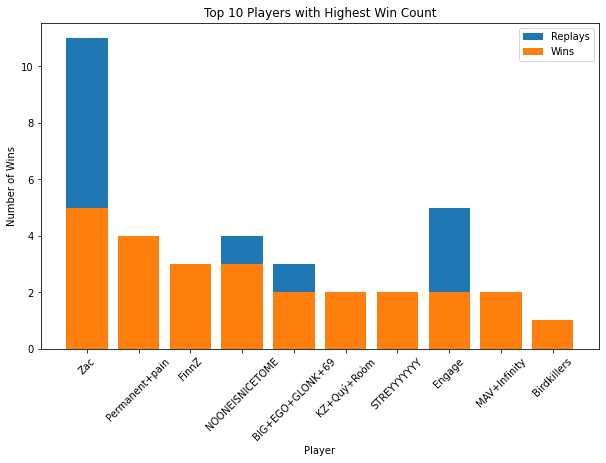

In [17]:
top_players = df.nlargest(10, "wins")

plt.figure(figsize=(10, 6))
plt.bar(top_players["summoner_name"], top_players["replays"], label="Replays")
plt.bar(top_players["summoner_name"], top_players["wins"], label="Wins")
plt.xlabel("Player")
plt.ylabel("Number of Wins")
plt.title("Top 10 Players with Highest Win Count")
plt.legend()
plt.xticks(rotation=45)
plt.savefig("top.jpg")
plt.show()

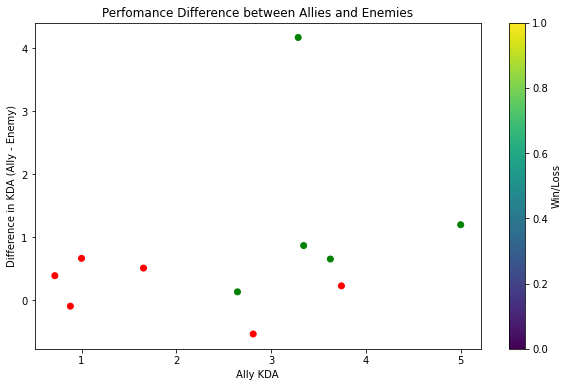

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(df_kda["kda_allies"], df_kda["diff"], c=df_kda["win"].map({"Victory": "green", "Defeat": "red"}))
plt.xlabel("Ally KDA")
plt.ylabel("Difference in KDA (Ally - Enemy)")
plt.title("Perfomance Difference between Allies and Enemies")
plt.colorbar(label="Win/Loss")
plt.savefig("performance.jpg")
plt.show()

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(top_players["summoner_name"], top_players["wins"])
plt.xlabel("Player")
plt.ylabel("Number of Wins")
plt.title("Top 10 Players with Highest Win Count")
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the spacing of the plot
plt.savefig("top.png", bbox_inches="tight", dpi=300)  # Save the plot as an image
plt.close()